In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss
from control.matlab import lsim
import random
from IPython.display import display, clear_output
from tqdm import tqdm

**The Tabular value-fucntion methods on the cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient.

# 1. Given the $\mathcal{X}$, $\mathcal{U}$ of the first hands-on define: the set of possible initial conditions of an episode; the terminal conditions of the episode


The set of all possibile initial conditions is:

$$
x = \left( \begin{array}{ccc}
                \theta \\
                \dot \theta \\
                p_c \\
                \dot p_c
\end{array} \right)
=
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)
$$

And the terminal episodes are:
1. if the pole is too unbalanced, $\theta = \{-25^\circ; 25^\circ \}$
2. if the cart is going out of the constraints $|p_c| > 5m$
3. if the control input force is too high $|u| > 10N$
4. If the episode is taking more than $5s$ to complete (500 time steps)

In [2]:
lowerBounds = [
    deg2rad(-25),
    -1,
    -5,
    -2
]
upperBounds = [- i for i in lowerBounds]
max_steps= 1000

# 2. Provide a proper discretization of the state space $\mathcal{X}$, and define the size of the action-value function $Q$

To discretise the system, all components of the state will be divided into 10 or 20 parts.

In [3]:
numberOfBins = [
    10,
    10,
    10,
    10
]

# 3. Create a code able to select the discretized version of a measured state $x$.


In [4]:
def discretize_state(state):
    angle    =      state[0]
    angularVelocity=state[1]
    position =      state[2]
    velocity =      state[3]

    poleAngleBin=np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
    poleAngleVelocityBin=np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
    cartPositionBin=np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
    cartVelocityBin=np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])

    indexAngle=np.maximum(np.digitize(angle,poleAngleBin)-1,0)
    indexAngularVelocity=np.maximum(np.digitize(angularVelocity,poleAngleVelocityBin)-1,0)
    indexPosition=np.maximum(np.digitize(position,cartPositionBin)-1,0)
    indexVelocity=np.maximum(np.digitize(velocity,cartVelocityBin)-1,0)

    return tuple([indexAngle,indexAngularVelocity,indexPosition,indexVelocity])

4.    Given the terminal conditions of the episode (selected in 1.) create a code able to perform a fixed number of episodes of a fixed number of steps, starting from random initial conditions and applying random inputs.

In [5]:
def is_terminal_state(dstate):
    # discretized state
    if dstate[0] == 0 or dstate[0] == numberOfBins[0]-1:
        return True
    if dstate[2] == 0 or dstate[2] == numberOfBins[2]-1:
        return True
    return False

5.   Create a function able to perform $\epsilon$-greedy policy for a chosen $\epsilon$.

```python
## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
if exp_exp_tradeoff > epsilon:
    action = np.argmax(qtable[state])

# Else doing a random choice --> exploration
else:
    action = random.randint(0,1)
```

# 6. Create a code that applies Tabular Q-Learning algorithm.

The possible inputs are either $F=10$ or $F=-10$, so just two actions are available.

To apply the Q-Learning algorithm

In [6]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

time_step=0.02
t0_odeint=0

In [7]:
total_episodes = 4000
learning_rate = 0.01
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.0001             # Exponential decay rate for exploration prob

action_size = 2 # left or right

In [8]:
def get_random_initial_state():
    return np.array([np.deg2rad(random.randint(-1,1))/10, 0.0, random.randint(-1,1)/10, 0.0]) # start out of equilibrium
    #return np.array([np.deg2rad(1), 0.0, 0.0, 0.0])

Initialize the Q-Learning table

In [9]:
qtable = np.zeros(tuple(numberOfBins) + (action_size, ))

In [10]:
rewards = []

In [11]:
total_episodes = 0

In [12]:
# List of rewards

for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state_c = get_random_initial_state()
    
    state = discretize_state(state_c)
    step = 0
    total_rewards = 0
    
    for step in range(max_steps):
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state])

        # Else doing a random choice --> exploration
        else:
            action = random.randint(0,1)
            
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        t1_odeint = t0_odeint+0.02
        t_odeint = np.array([t0_odeint, t1_odeint])
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretize_state(new_state_c)
        
        if is_terminal_state(new_state):
            reward = -100
        else:
            reward = 1

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state + (action,)] = qtable[state + (action,)] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state + (action,)])
        
        total_rewards =total_rewards + reward
        
        # Our new state is state
        state = new_state
        state_c = new_state_c

        
        # If done (if we're dead) : finish episode
        if is_terminal_state(new_state):
            break
        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    
    clear_output(wait=True)
    display('Episode '+str(episode)+'; epsilon: '+str(epsilon)+"; reward:"+str(total_rewards))


print ("Score over time: " +  str(sum(rewards)/total_episodes))
print("Epsilon:", epsilon)

0it [00:00, ?it/s]

Score over time: nan
Epsilon: 1.0



/tmp/ipykernel_9841/2238742284.py:64: RuntimeWarning: invalid value encountered in scalar divide
  print ("Score over time: " +  str(sum(rewards)/total_episodes))


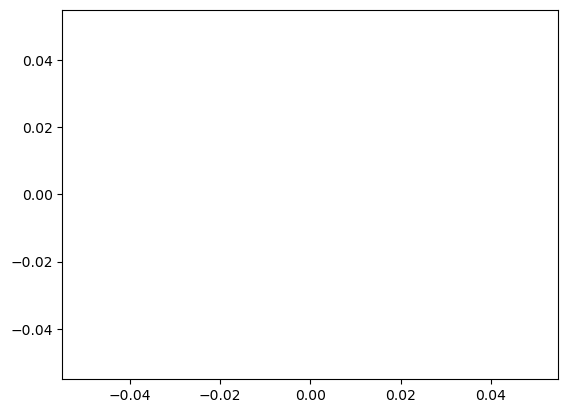

In [13]:
plt.plot(rewards, 'r', label='U(t)')

The reward is increasing over time and this is good, but it's not really improving much. It looks like as the $\epsilon$ value is decreasing, thus there's not much exploration taking place, the algorithm will not make any improvements.

### Run the simulation

In [14]:
x0_odeint = get_random_initial_state()
X_odeint = [x0_odeint]
uvec = []

state_c = x0_odeint
state = discretize_state(state_c)
total_rewards = 0

for step in range(max_steps):
    action = np.argmax(qtable[state])

    # convert action into force
    if action == 1:
        F = 10
    else:
        F = -10
        
    uvec.append(F)

    # Simulate the system
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
    new_state_c = x_odeint[1]
    new_state = discretize_state(new_state_c)
    X_odeint=np.append(X_odeint, [state_c], axis= 0)

    if is_terminal_state(new_state):
        reward = -10
    else:
        reward = 1

    total_rewards =total_rewards + reward

    # Our new state is state
    state = new_state
    state_c = new_state_c

    # If done (if we're dead) : finish episode
    if is_terminal_state(new_state):
        break

Time: 0.22


Text(0.5, 1.0, 'dot p_c(t)')

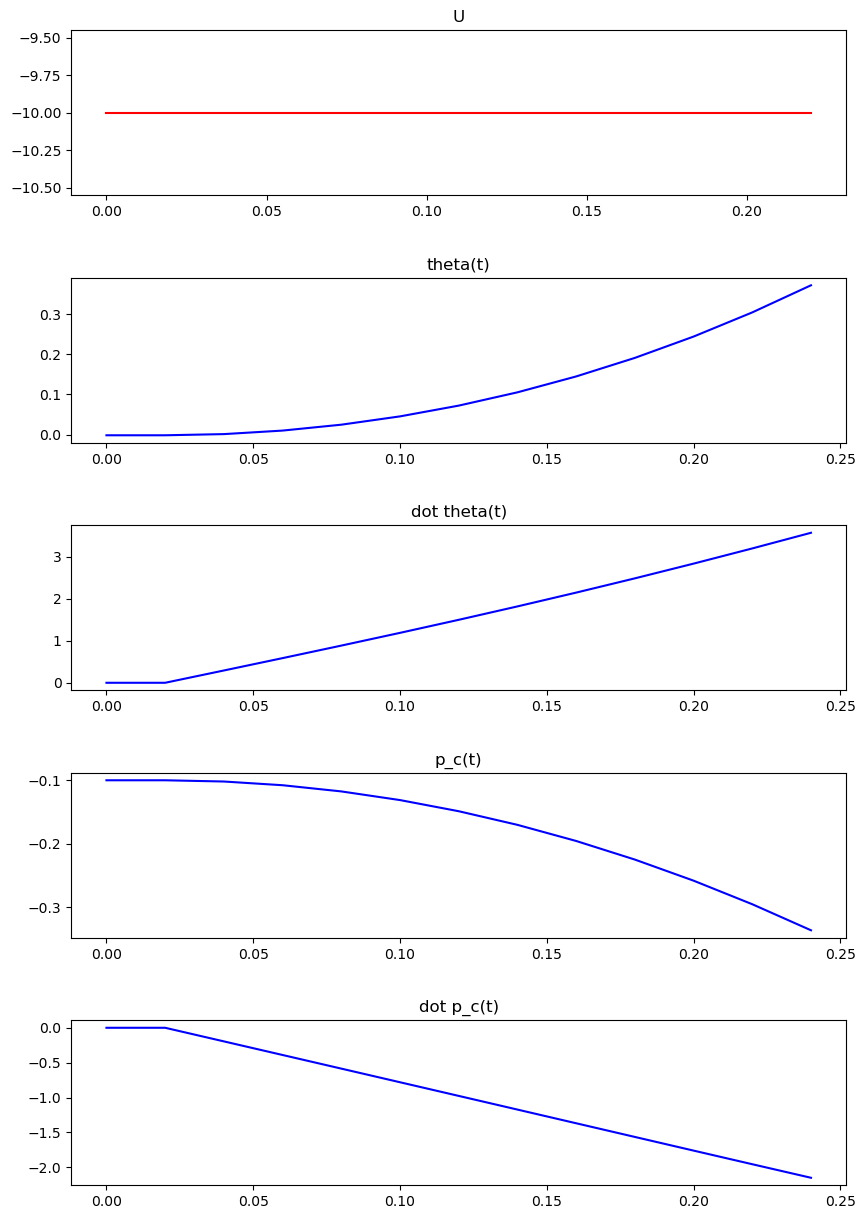

In [15]:
print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
time_sim=np.arange(0.0, 10+time_step, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

The simulation lasted for 2.66s, which is not satisfying the project specifications. Such a poor behavior is due to the simple reward function that's being calculated. We are not keeping into account the movement of the cart and the speed at which the pendulum and the cart itself are moving. A more complex reward function can fill the Q-Table better and this will lead to a better performance.

7.    Copy and paste your Q-learning algorithm and apply the changes needed to convert it into a SARSA algorithm

In [16]:
qtable_sarsa = np.zeros(tuple(numberOfBins) + (action_size, ))

In [17]:
rewards = []

In [18]:
total_episodes = 20000

In [21]:
# List of rewards
#desired_state_c = [0,0,0,0]
#desired_state = discretize_state(desired_state_c)

# 2 For life or until learning is stopped
for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state_c = get_random_initial_state()
    state = discretize_state(state_c)
    step = 0
    total_rewards = 0
    
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        action = np.argmax(qtable_sarsa[state])

    # Else doing a random choice --> exploration
    else:
        action = random.randint(0,1)
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            new_action = np.argmax(qtable_sarsa[state])

        # Else doing a random choice --> exploration
        else:
            new_action = random.randint(0,1)
            
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        t1_odeint = t0_odeint+0.02
        t_odeint = np.array([t0_odeint, t1_odeint])
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretize_state(new_state_c)
        
        if is_terminal_state(new_state):
            reward = -10
        else:
            reward = 1

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable_sarsa[state + (action,)] = qtable_sarsa[state + (action,)] + learning_rate * (reward + gamma * qtable_sarsa[new_state + (new_action,)] - qtable_sarsa[state + (action,)])
        
        total_rewards =total_rewards + reward
        
        # Our new state is state
        state = new_state
        state_c = new_state_c
        
        action = new_action

        
        # If done (if we're dead) : finish episode
        if is_terminal_state(new_state):
            break
        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    
    # clear_output(wait=True)
    # display('Episode '+str(episode)+'; epsilon: '+str(epsilon)+"; reward:"+str(total_rewards))
    if episode % 5000 == 0:
        print('Episode '+str(episode)+'; epsilon: '+str(epsilon)+"; reward:"+str(np.average(rewards)))
    
print ("Score over time: " +  str(sum(rewards)/total_episodes))
#print(qtable)
#print(epsilon)


 25%|█████████▌                            | 5011/20000 [01:18<05:20, 46.74it/s]

Episode 5000; epsilon: 0.6104653531155071; reward:23.4404


 50%|██████████████████▌                  | 10003/20000 [03:58<08:00, 20.79it/s]

Episode 10000; epsilon: 0.3742006467597279; reward:40.2544


 75%|███████████████████████████▊         | 15003/20000 [08:44<05:29, 15.17it/s]

Episode 15000; epsilon: 0.23089885854694553; reward:64.89173333333333


100%|█████████████████████████████████████| 20000/20000 [14:32<00:00, 22.92it/s]

Episode 20000; epsilon: 0.1439819304042466; reward:84.32535
Score over time: 84.32535


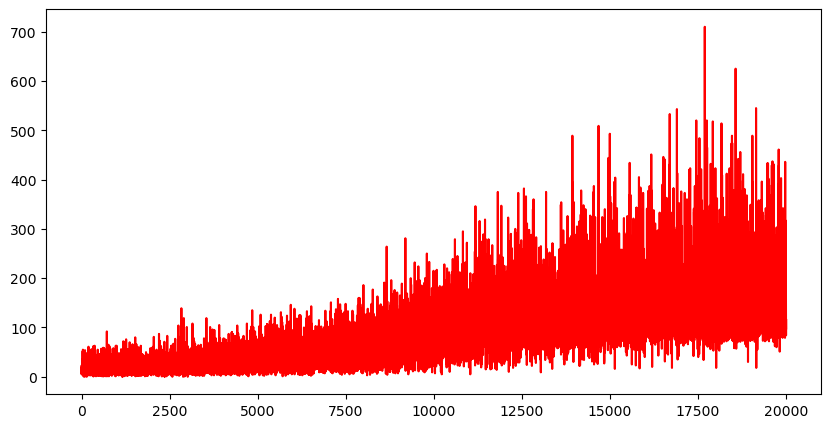

In [22]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(rewards, 'r', label='U(t)')

This time we see higher rewards, but after 2000 steps our model is not improving anymore.

## Export the q matrix

In [ ]:
#with open("qtable.npy", "wb") as f:
#    np.save(f, qtable)

In [19]:
#with open("qtable_sarsa.npy", "wb") as f:
#    np.save(f, qtable_sarsa)

### Run the simulation

In [23]:
x0_odeint = get_random_initial_state()
X_odeint = [x0_odeint]
uvec = []

state_c = x0_odeint
state = discretize_state(state_c)
total_rewards = 0

for step in range(max_steps):
    action = np.argmax(qtable_sarsa[state])

    # convert action into force
    if action == 1:
        F = 10
    else:
        F = -10
        
    uvec.append(F)

    # Simulate the system
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
    new_state_c = x_odeint[1]
    new_state = discretize_state(new_state_c)
    X_odeint=np.append(X_odeint, [state_c], axis= 0)

    if is_terminal_state(new_state):
        reward = -100
    else:
        reward = 1

    total_rewards =total_rewards + reward

    # Our new state is state
    state = new_state
    state_c = new_state_c

    # If done (if we're dead) : finish episode
    if is_terminal_state(new_state):
        break

Time: 1.94


Text(0.5, 1.0, 'dot p_c(t)')

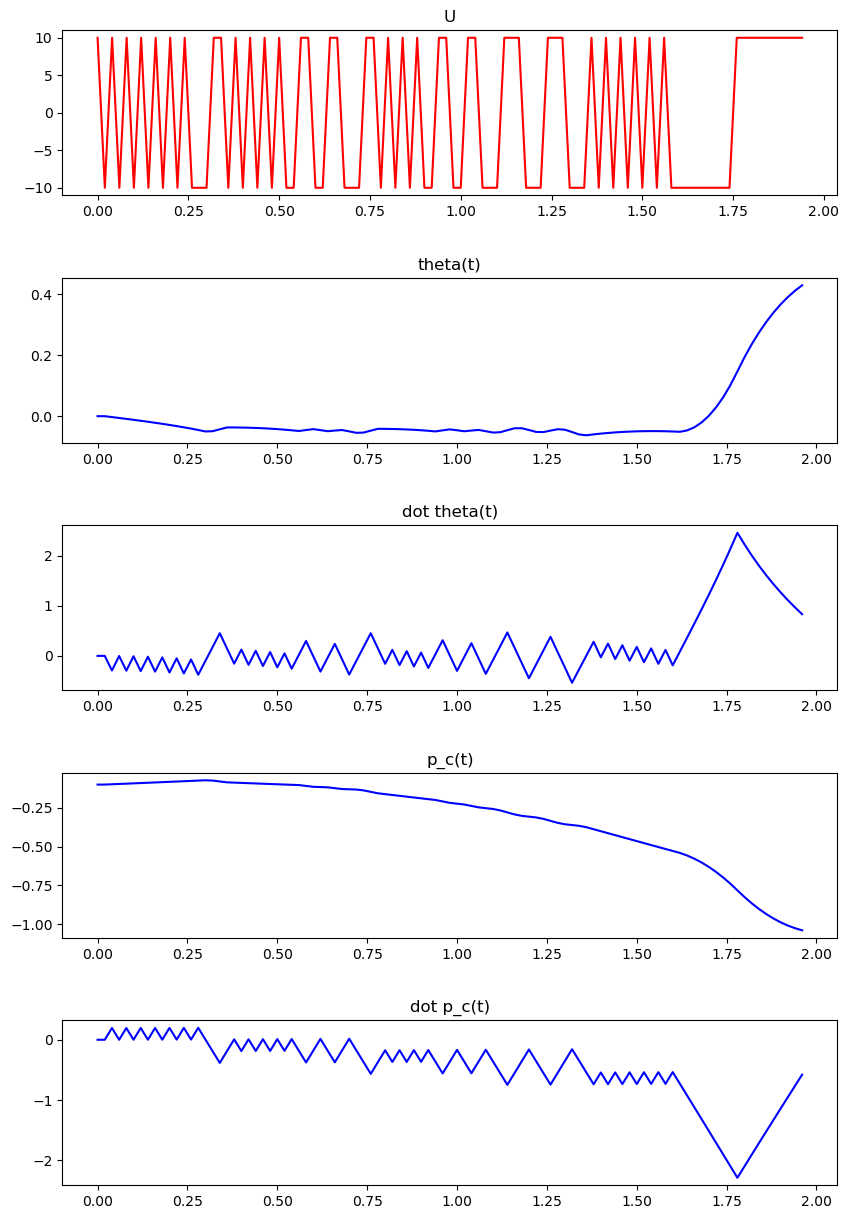

In [24]:
print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
time_sim=np.arange(0.0, 10+time_step, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

Sarsa algorithm sometimes is having a better performance compared to the non-sarsa. This is because of how the cost function is being calculated.